In [1]:
import pandas as pd
import numpy as np
import keras
import scipy
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.model_selection import GroupKFold
from sklearn import linear_model
from lineartree import RandomForestRegressor
from sklearn import metrics
from scipy.signal import savgol_filter
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [2]:
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

In [3]:
def rae(actual, predicted):
    actual = np.asarray(actual).reshape(-1,1)
    predicted = np.asarray(predicted).reshape(-1,1)
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    return numerator / denominator

In [4]:
def peak_eV_nm(peak_eV):
    peak_eV = np.asarray(peak_eV).reshape(-1,1)
    return 1239.84193/peak_eV

In [5]:
def FWHM_eV_nm(peak_eV,fwhm_eV):
    peak_eV = np.asarray(peak_eV).reshape(-1,1)
    fwhm_eV = np.asarray(fwhm_eV).reshape(-1,1)
    return  2*(1239.84193/(peak_eV-fwhm_eV/2) - 1239.84193/(peak_eV))

In [6]:
def predict_dist(X, model, num_samples):
    preds = [model(X, training=True) for _ in range(num_samples)]
    return np.hstack(preds)

In [7]:
def predict_point(X, model, num_samples):
    pred_dist = predict_dist(X, model, num_samples)
    return pred_dist.mean(axis=1)

In [8]:
#Define models

initializer = keras.initializers.HeNormal(seed=1)
opt = keras.optimizers.Adam(learning_rate=0.001)

model_peak = keras.models.Sequential()
model_peak.add(Dense(5, input_shape=(5,), kernel_initializer=initializer, activation='relu'))
model_peak.add(Dense(50,  activation='relu'))
model_peak.add(keras.layers.Dropout(0.1))
model_peak.add(Dense(50,  activation='relu'))
model_peak.add(keras.layers.Dropout(0.1))
model_peak.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_peak.compile(loss='mean_squared_error', optimizer= opt)

model_fwhm = keras.models.Sequential()
model_fwhm.add(Dense(5, input_shape=(5,), kernel_initializer=initializer, activation='relu'))
model_fwhm.add(Dense(50,  activation='relu'))
model_fwhm.add(keras.layers.Dropout(0.1))
model_fwhm.add(Dense(50,  activation='relu'))
model_fwhm.add(keras.layers.Dropout(0.1))
model_fwhm.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_fwhm.compile(loss='mean_squared_error', optimizer= opt)

model_cascade = keras.models.Sequential()
model_cascade.add(Dense(6, input_shape=(6,), kernel_initializer=initializer, activation='relu'))
model_cascade.add(Dense(50,  activation='relu'))
model_cascade.add(keras.layers.Dropout(0.1))
model_cascade.add(Dense(50,  activation='relu'))
model_cascade.add(keras.layers.Dropout(0.1))
model_cascade.add(Dense(1, kernel_initializer=initializer))
# Compile model
model_cascade.compile(loss='mean_squared_error', optimizer= opt)

In [9]:
# Train model on entire dataset (Absorbance)
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

matrix = np.zeros([1,8])
matrix_fwhm = np.zeros([1,8])
matrix_cascade = np.zeros([1,8])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
X2_test = X2
y_test = y
z_test = z
j=0

#Initialize with fixed weights
model_peak.load_weights('initialize_weights3.h5')
model_fwhm.load_weights('initialize_weights3.h5')
model_cascade.load_weights('initialize_weights4.h5')

#Train models
#prediction for Peak
model_peak.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test),verbose = 1, use_multiprocessing=False, workers = 100)
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
model_fwhm.fit(X_train, z_train, epochs=300, validation_data=(X_test, z_test),verbose = 1, use_multiprocessing=False, workers = 100)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
model_cascade.fit(X2_train, z_train, epochs=300, validation_data=(X2_test, z_test),verbose = 1, use_multiprocessing=False, workers = 100)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

# serialize weights to HDF5
model_peak.save_weights("Abs_peak.h5")
model_fwhm.save_weights("Abs_fwhm.h5")
model_cascade.save_weights("Abs_cascade.h5")

Epoch 1/300
155/155 [==============================] - 1s 3ms/step - loss: 0.0380 - val_loss: 0.0132
Epoch 2/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0091
Epoch 3/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0102 - val_loss: 0.0073
Epoch 4/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0067
Epoch 5/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0067
Epoch 6/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0067
Epoch 7/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 8/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 9/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 10/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0071 - val_lo

Epoch 161/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 162/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 163/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 164/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 165/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 166/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 167/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 168/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 169/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 170/300
155/155 [==============================] - 0s 2ms/step - lo

155/155 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 20/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 21/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 22/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 23/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 24/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 25/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 26/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 27/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 28/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 

155/155 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 179/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 180/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 181/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 182/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 183/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 184/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 185/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 186/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 187/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0013 - v

155/155 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 37/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 38/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 39/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 40/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 41/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 42/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 43/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 44/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 45/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 

155/155 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 9.5121e-04
Epoch 117/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 9.6942e-04
Epoch 118/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 119/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 120/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 121/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 9.6619e-04
Epoch 122/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 123/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 124/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 125/300
155/155 [==============================] - 0s 2ms/step - loss

Epoch 194/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 195/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.8262e-04
Epoch 196/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 197/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.8712e-04
Epoch 198/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 9.0971e-04
Epoch 199/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.3021e-04
Epoch 200/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 201/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 9.6772e-04
Epoch 202/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.6737e-04
Epoch 203/300
155/155 [==========================

Epoch 271/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.3494e-04
Epoch 272/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 8.7522e-04
Epoch 273/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 9.6742e-04
Epoch 274/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 9.1409e-04
Epoch 275/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.5056e-04
Epoch 276/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.6504e-04
Epoch 277/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.1565e-04
Epoch 278/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 8.3012e-04
Epoch 279/300
155/155 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 9.1894e-04
Epoch 280/300
155/155 [==============

In [10]:
#Predictions with dropout

# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

matrix = np.zeros([1,8])
matrix_fwhm = np.zeros([1,8])
matrix_cascade = np.zeros([1,8])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Absorption Peak/FWHM Training Accuracy (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0493
R2 (eV):	 0.8919
RAE (eV):	 0.3134
RMSE (eV):	 0.0625
MAE (nm):	 10.5614
R2 (nm):	 0.8840
RAE (nm):	 0.3209
RMSE (nm):	 13.4028
Absorbance FWHM (direct)
MAE (eV):	 0.0077
R2 (eV):	 0.7969
RAE (eV):	 0.3827
RMSE (eV):	 0.0114
MAE (nm):	 2.3010
R2 (nm):	 0.7705
RAE (nm):	 0.4245
RMSE (nm):	 3.1488
Absorbance FWHM (cascade)
MAE (eV):	 0.0067
R2 (eV):	 0.8500
RAE (eV):	 0.3338
RMSE (eV):	 0.0098
MAE (nm):	 2.1284
R2 (nm):	 0.8126
RAE (nm):	 0.3927
RMSE (nm):	 2.8457


In [11]:
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

background = X.sample(n = 500)
background2 = X2.sample(n = 500)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4946 [00:00<?, ?it/s]

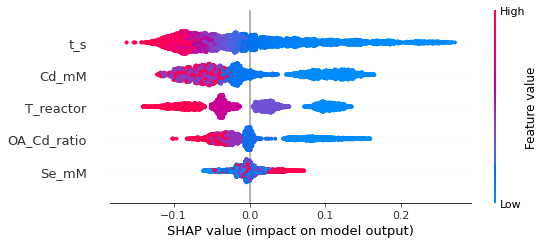

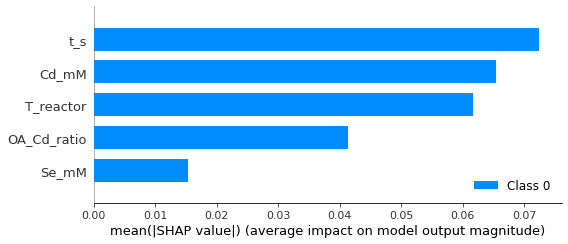

In [12]:
#SHAP on training data for Peak
import shap
explainer = shap.KernelExplainer(model_peak, background)
shap_values1 = explainer.shap_values(X)
shap.summary_plot(shap_values1[0], X)
shap.summary_plot(shap_values1, X, plot_type="bar")

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4946 [00:00<?, ?it/s]

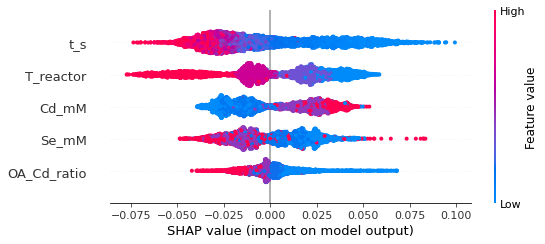

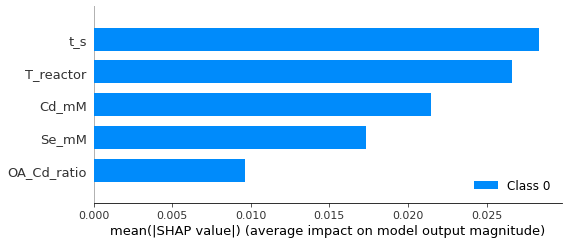

In [13]:
#SHAP on training data for FWHM
explainer = shap.KernelExplainer(model_fwhm, background)
shap_values2 = explainer.shap_values(X)
shap.summary_plot(shap_values2[0], X)
shap.summary_plot(shap_values2, X, plot_type="bar")

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/4946 [00:00<?, ?it/s]

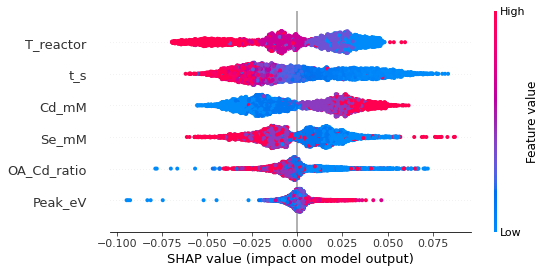

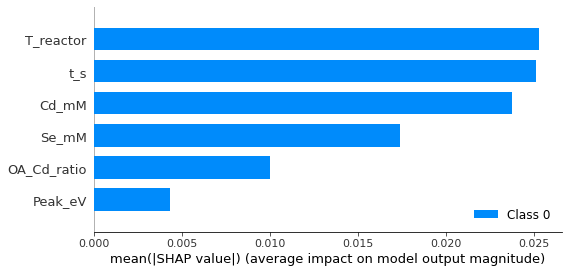

In [14]:
#SHAP on training data for FWHM (cascade)
explainer = shap.KernelExplainer(model_cascade, background2)
shap_values3 = explainer.shap_values(X2)
shap.summary_plot(shap_values3[0], X2)
shap.summary_plot(shap_values3, X2, plot_type="bar")

In [15]:
#Test NN on interpolation without dropout, UV Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe UV Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z


#prediction for Peak
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("NN_UV_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("NN_UV_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("NN_UV_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

15/15 [==============================] - 0s 717us/step
Absorption Peak/FWHM Interpolation (no dropout at inference)
Absorbance Peak
MAE (eV):	 0.0273
R2 (eV):	 0.9559
RAE (eV):	 0.2072
RMSE (eV):	 0.0332
MAE (nm):	 5.8819
R2 (nm):	 0.9555
RAE (nm):	 0.2086
RMSE (nm):	 7.0204
Absorbance FWHM (direct)
MAE (eV):	 0.0075
R2 (eV):	 0.8329
RAE (eV):	 0.3745
RMSE (eV):	 0.0101
MAE (nm):	 1.7068
R2 (nm):	 0.8481
RAE (nm):	 0.3165
RMSE (nm):	 2.4574
Absorbance FWHM (cascade)
MAE (eV):	 0.0065
R2 (eV):	 0.8605
RAE (eV):	 0.3284
RMSE (eV):	 0.0092
MAE (nm):	 1.5321
R2 (nm):	 0.8774
RAE (nm):	 0.2842
RMSE (nm):	 2.2077


In [16]:
#Test NN on interpolation with dropout, UV Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe UV Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("MCNN_UV_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("MCNN_UV_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("MCNN_UV_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Interpolation (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0256
R2 (eV):	 0.9596
RAE (eV):	 0.1947
RMSE (eV):	 0.0318
MAE (nm):	 5.4891
R2 (nm):	 0.9601
RAE (nm):	 0.1947
RMSE (nm):	 6.6464
Absorbance FWHM (direct)
MAE (eV):	 0.0073
R2 (eV):	 0.8375
RAE (eV):	 0.3684
RMSE (eV):	 0.0099
MAE (nm):	 1.6882
R2 (nm):	 0.8560
RAE (nm):	 0.3131
RMSE (nm):	 2.3924
Absorbance FWHM (cascade)
MAE (eV):	 0.0066
R2 (eV):	 0.8592
RAE (eV):	 0.3337
RMSE (eV):	 0.0093
MAE (nm):	 1.5394
R2 (nm):	 0.8789
RAE (nm):	 0.2855
RMSE (nm):	 2.1941


In [17]:
#Test Linear model on extrapolation, UV Peak, FWHM (eV)

#Test data set (extrapolation)
df2 = pd.read_csv('CdSe UV Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = model_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = model_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", model_peak.predict(X_test), True)
y_pred_cascade = model_cascade.predict(X_test)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation (no dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("NN_UV_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("NN_UV_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("NN_UV_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

12/12 [==============================] - 0s 816us/step
Absorption Peak/FWHM Extrapolation (no dropout at inference)
Absorbance Peak
MAE (eV):	 0.0495
R2 (eV):	 0.8988
RAE (eV):	 0.2991
RMSE (eV):	 0.0633
MAE (nm):	 10.3728
R2 (nm):	 0.9053
RAE (nm):	 0.2929
RMSE (nm):	 12.8858
Absorbance FWHM (direct)
MAE (eV):	 0.0214
R2 (eV):	 -0.0187
RAE (eV):	 0.7932
RMSE (eV):	 0.0318
MAE (nm):	 4.6089
R2 (nm):	 -0.8890
RAE (nm):	 1.0210
RMSE (nm):	 7.2263
Absorbance FWHM (cascade)
MAE (eV):	 0.0836
R2 (eV):	 -12.4086
RAE (eV):	 3.0966
RMSE (eV):	 0.1155
MAE (nm):	 19.5128
R2 (nm):	 -24.4697
RAE (nm):	 4.3224
RMSE (nm):	 26.5347


In [18]:
#Test NN on interpolation with dropout, UV Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe UV Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

X_test_t = K.constant(X_test)

#prediction for Peak
y_pred =  predict_point(X_test_t, model_peak, 1000)
#prediction for FWHM (direct)
y_pred_fwhm = predict_point(X_test_t, model_fwhm, 1000)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", y_pred, True)
X_test_t = K.constant(X_test)
y_pred_cascade = predict_point(X_test_t, model_cascade, 1000)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation (with dropout at inference)' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test = y_test.to_numpy().reshape(1,-1)
z_test = z_test.to_numpy().reshape(1,-1)
y_pred = y_pred.reshape(1,-1)
y_pred_fwhm = y_pred_fwhm.reshape(1,-1)
y_pred_cascade = y_pred_cascade.reshape(1,-1)

np.savetxt("MCNN_UV_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("MCNN_UV_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("MCNN_UV_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Extrapolation (with dropout at inference)
Absorbance Peak
MAE (eV):	 0.0499
R2 (eV):	 0.8983
RAE (eV):	 0.3014
RMSE (eV):	 0.0634
MAE (nm):	 10.4637
R2 (nm):	 0.9047
RAE (nm):	 0.2954
RMSE (nm):	 12.9272
Absorbance FWHM (direct)
MAE (eV):	 0.0214
R2 (eV):	 -0.0044
RAE (eV):	 0.7941
RMSE (eV):	 0.0316
MAE (nm):	 4.6485
R2 (nm):	 -0.9303
RAE (nm):	 1.0297
RMSE (nm):	 7.3049
Absorbance FWHM (cascade)
MAE (eV):	 0.0867
R2 (eV):	 -13.5907
RAE (eV):	 3.2093
RMSE (eV):	 0.1205
MAE (nm):	 20.3666
R2 (nm):	 -26.9931
RAE (nm):	 4.5115
RMSE (nm):	 27.8181
